# Where is the ball game

In [ ]:
import time
from naoqi import ALProxy
from naoqi import ALBroker
from naoqi import ALModule

In [ ]:
class Robot(ALModule):
    def __init__(self, name):
        self._name = name
        self.broker = ALBroker("myBroker",
           "0.0.0.0",   # listen to anyone
           0,           # find a free port and use it
           self._name + ".brynmawr.edu",         # parent broker IP
           9559)       # parent broker port

        ALModule.__init__(self, name)
        
        #Initializes APIs I will use
        self.tts = ALProxy("ALTextToSpeech")
        self.posture = ALProxy("ALRobotPosture")
        self.motion = ALProxy("ALMotion")
        self.memory = ALProxy("ALMemory")
        
        self.awareness = ALProxy("ALBasicAwareness")
        
        def cover_eyes(self):
            self.awareness.stopAwareness()
            self.motion.setStiffnesses("Head", 1.0)
            self.motion.setAngles("HeadPitch", 0, 0.1)
            self.motion.setAngles("HeadYaw", 0, 0.1)
            self.motion.setStiffnesses("Body", 1.0)
            self.motion.setAngles("RShoulderRoll", [-0.0614018440246582], 0.5)
            self.motion.setAngles("RElbowRoll", [1.2809319496154785], 0.5 )
            self.motion.setAngles("RElbowYaw", [0.5414600372314453], 0.5 )
            self.motion.setAngles("RShoulderPitch", [0.05364799499511719], 0.5 )

            self.motion.setAngles("LShoulderRoll", [0.0614018440246582], 0.5)
            self.motion.setAngles("LElbowRoll", [-1.2809319496154785], 0.5 )
            self.motion.setAngles("LElbowYaw", [-0.5414600372314453], 0.5 )
            self.motion.setAngles("LShoulderPitch", [-0.05364799499511719], 0.5 )

        def uncover_eyes(self):
            self.awareness.startAwareness()
            self.motion.setStiffnesses("Body", 1.0)
            self.motion.setAngles("RShoulderRoll", [-0.25928807258605957], 0.5)
            self.motion.setAngles("RElbowRoll", [1.245649814605713], 0.5 )
            self.motion.setAngles("RElbowYaw", [0.5015759468078613], 0.5 )
            self.motion.setAngles("RShoulderPitch", [0.964928150177002], 0.5 )

            self.motion.setAngles("LShoulderRoll", [0.25928807258605957], 0.5)
            self.motion.setAngles("LElbowRoll", [-1.245649814605713], 0.5 )
            self.motion.setAngles("LElbowYaw", [-0.5015759468078613], 0.5 )
            self.motion.setAngles("LShoulderPitch", [0.964928150177002], 0.5 )

        self.tts.say("Hello, my name is "+ self._name + "Let's play a game called" "Where's the ball")
        
        #self.posture.goToPosture("StandInit", 0.5)
        uncover_eyes(self)
        currentPosture = self.posture.getPosture()
        
        if currentPosture != 'Sit':
            self.tts.say("First, place me in an open space so I can sit down.")
            time.sleep(5.0)
            self.posture.goToPosture("Sit", 0.5)
            time.sleep(3.0)
            self.tts.say("Thank you, now I feel great.")
            
        self.tts.say("Grab the red ball and hide it from me." + 
                     " I will tell you once I see the ball.")
        
        self.lastSeen = 0
        self.lastNotSeen = 0
        
        START = time.time()

        while time.time() - START < 10:

            cover_eyes(self)

            if time.time() - self.lastNotSeen > 5:
                self.tts.say("Where's the ball? I don't see the ball")
                self.lastNotSeen = time.time()    
        
        uncover_eyes(self)

        self.memory.subscribeToEvent("redBallDetected",
            self._name,
            "onredBallDetected")

    
    def onredBallDetected(self, *args):
        # Unsubscribe to the event when talking,
        # to avoid repetitions

        self.memory.unsubscribeToEvent("redBallDetected",
            self._name)
        if time.time() - self.lastSeen > 5:
            self.tts.say("I see the ball")
            self.lastSeen = time.time()
            
        # Subscribe again to the event
        self.memory.subscribeToEvent("redBallDetected",
            self._name,
            "onredBallDetected")
    
    def stop(self):
        self.memory.unsubscribeToEvent("redBallDetected",
            self._name)
        self.broker.shutdown()

In [ ]:
hedwig = Robot("hedwig")

In [ ]:
hedwig.stop()

# Recognizing and tracking an object

In [1]:
from naoqi import ALProxy
import time
import sys
import Image
import vision_definitions

In [2]:
class Robot:
    def __init__(self, ip, port):
        self.ip = ip
        self.port = port
        
        #Initializes all the APIs I will use
        self.tts = ALProxy("ALTextToSpeech", ip, port)
        self.rbd = ALProxy("ALRedBallTracker", ip, port)
        self.visual = ALProxy("ALVideoDevice", ip, port)
        self.motion = ALProxy("ALMotion", ip, port)
        self.life = ALProxy("ALAutonomousLife", ip, port)
        self.posture = ALProxy("ALRobotPosture", ip, port)
        
        #Robot says "okay" after it initializes APIs
        #Disables robot's autonomous life
        self.tts.say("okay")
        self.life.setState("disabled")
        
    def save_photo(self, img_name): #takes 30x40 photo and saves to .py file directory
        print ("Taking photo: " + img_name)
        vidClient = self.visual.subscribeCamera("python_client", 0, 2, 11, 5) #initialize cam with settings
        naoImage = self.visual.getImageRemote(vidClient) #taking photo
        time.sleep(0.5)
        self.visual.unsubscribe(vidClient) #unsubscribe
        imageWidth = naoImage[0]
        imageHeight = naoImage[1]
        array = naoImage[6]
        img = Image.frombytes("RGB", (imageWidth, imageHeight), array)
        img.save(img_name + ".jpeg", "JPEG")
        print ("Photo " + img_name + " saved!")
        
    def set_neutral(self):
        self.motion.setStiffnesses("Head", 1.0)
        self.motion.setAngles("HeadPitch", 0, 0.1)
        self.motion.setAngles("HeadYaw", 0, 0.1)
        time.sleep(3.0)
        self.motion.setStiffnesses("Head", 0)
        
    def recognize_and_track(self, target_name, img_name):
            #Sets Nao's head to neutral, saves an image, then tracks the object
            #Says its found the object once it sees it
            #Sets head to neutral after tracker stops

            self.set_neutral()
            time.sleep(1.0)
            self.save_photo(img_name)
            self.motion.setStiffnesses("Head", 1.0)
            self.rbd.startTracker()
            print "Starting tracker"
            time.sleep(1.5)
            self.tts.say("Found " + target_name)
            time.sleep(15.0)
            print "Stopping tracker"
            self.rbd.stopTracker()
            self.motion.setStiffnesses("Head", 0)
            self.set_neutral()

In [3]:
def test():
    hedwig = Robot("hedwig.brynmawr.edu", 9559)
    hedwig.recognize_and_track("circle", "circlePhoto")

In [4]:
test()

Taking photo: circlePhoto
Photo circlePhoto saved!
Starting tracker
Stopping tracker


# Printing continuous pictures

In [1]:
# Get an image from NAO. Display it and save it using PIL.

import sys
import time

# Python Image Library
from PIL import Image

from naoqi import ALProxy

import IPython.display as display

In [2]:
def showNaoImage(IP, PORT):
    """
    First get an image from Nao, then show it on the screen with PIL.
    """
    camProxy = ALProxy("ALVideoDevice", IP, PORT)

    videoClient = camProxy.subscribe("python_client", 2, 11, 5)

    t0 = time.time()

    # Get a camera image.
    # image[6] contains the image data passed as an array of ASCII chars.
    naoImage = camProxy.getImageRemote(videoClient)

    t1 = time.time()

    # Time the image transfer.
    print "acquisition delay ", t1 - t0

    camProxy.unsubscribe(videoClient)


    # Now we work with the image returned and save it as a PNG  using ImageDraw
    # package.

    # Get the image size and pixel array.
    imageWidth = naoImage[0]
    imageHeight = naoImage[1]
    array = naoImage[6]

    # Create a PIL Image from our pixel array.
    im = Image.frombytes("RGB", (imageWidth, imageHeight), array)

    # Save the image.
    im.save("camImage.png", "PNG")
    print "Saving image"
    return "camImage.png"

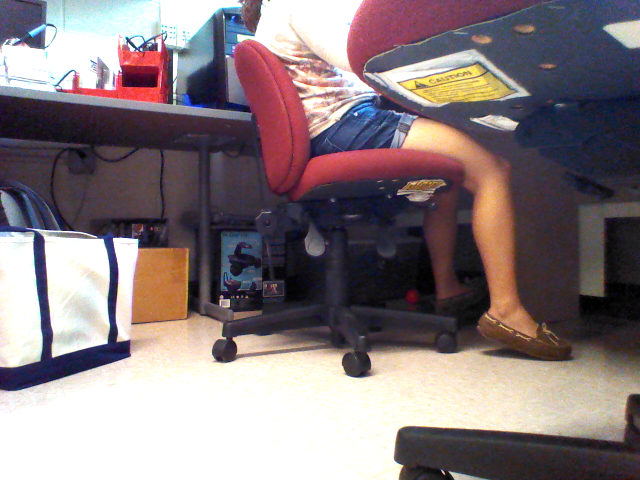

In [ ]:
for i in range(10):
        filename = showNaoImage("hedwig.brynmawr.edu", 9559)
        display.clear_output(wait=True)
        display.display(display.Image(filename=filename))
        time.sleep(1)

# Nao useful methods

In [1]:
from naoqi import ALProxy
import time
import sys
import Image
import vision_definitions

#IP's of NAOs
    #hedwig - 165.106.241.201
    #hoots - 165.106.241.202
    #nyctimene - 165.106.241.203
    #wol - 165.106.241.204

In [ ]:
class Robot:
    
    #class constructor below
    def __init__(self, ip, port):
        
        self.ip = ip
        self.port = port
        
        #Initialies APIs here
        self.tts = ALProxy("ALTextToSpeech", ip, port)
        self.rbd = ALProxy("ALRedBallTracker", ip, port) 
        self.visual = ALProxy("ALVideoDevice", ip, port)
        self.motion = ALProxy("ALMotion", ip, port)
        self.memory = ALProxy("ALMemory", ip, port)
        self.life = ALProxy("ALAutonomousLife", ip, port)
        self.posture = ALProxy("ALRobotPosture", ip, port)
        self.aware = ALProxy("ALBasicAwareness", ip, port)
        self.behave = ALProxy("ALBehaviorManager", ip, port)
        self.tracker = ALProxy("ALTracker", ip, port)
        self.tts.say("ok")
        self.life.setState("disabled")

    def say(self, text):
        self.tts.say(text)
    
    #sets Nao's head in neutral position
    def set_neutral(self):
        self.motion.setStiffnesses("Head", 1.0)
        self.motion.setAngles("HeadPitch", 0, 0.1)
        self.motion.setAngles("HeadYaw", 0, 0.1)
        time.sleep(3.0)
        self.motion.setStiffnesses("Head", 0)
    
    #Gets Nao's ShoulderRoll, ElbowRoll, ElbowYaw, and ShoulderPirch joint angles
    #It prints out angle joints when Nao is in the sitting position
    
    def get_angles_neutral(self):
        self.posture.goToPosture("Sit", 0.5)
        temp = self.motion.getAngles("RShoulderRoll", True)
        temp1 = self.motion.getAngles("RElbowRoll", True)
        temp2 = self.motion.getAngles("RElbowYaw", True)
        temp4 = self.motion.getAngles("RShoulderPitch", True)
        temp5 = self.motion.getAngles("LShoulderRoll", True)
        temp6 = self.motion.getAngles("LElbowRoll", True)
        temp7 = self.motion.getAngles("LElbowYaw", True)
        temp8 = self.motion.getAngles("LShoulderPitch", True)
        print "RShoulderRoll", temp
        print "LShoulderRoll", temp5
        print " "
        print "RElbowRoll", temp1
        print "LElbowRoll", temp6
        print " "
        print "RElbowYaw", temp2 
        print "LElbowYaw", temp7
        print " "
        print "RShoulderPitch", temp4
        print "LShoulderPitch", temp8
    
    #Gets Nao's ShoulderRoll, ElbowRoll, ElbowYaw, and ShoulderPirch joint angles
    #It prints out angle joints when you manually/phisically raise robot hands
    #You are given 10 seconds to set Nao's arm to the desired position 
    
    
    def get_angles_raised(self):
        self.motion.setStiffnesses("Body", 0)
        time.sleep(10.0)
        self.motion.setStiffnesses("Body", 1.0)
        temp = self.motion.getAngles("RShoulderRoll", True)
        temp1 = self.motion.getAngles("RElbowRoll", True)
        temp2 = self.motion.getAngles("RElbowYaw", True)
        temp4 = self.motion.getAngles("RShoulderPitch", True)
        temp5 = self.motion.getAngles("LShoulderRoll", True)
        temp6 = self.motion.getAngles("LElbowRoll", True)
        temp7 = self.motion.getAngles("LElbowYaw", True)
        temp8 = self.motion.getAngles("LShoulderPitch", True)
        print "RShoulderRoll", temp
        print "LShoulderRoll", temp5
        print " "
        print "RElbowRoll", temp1
        print "LElbowRoll", temp6
        print " "
        print "RElbowYaw", temp2 
        print "LElbowYaw", temp7
        print " "
        print "RShoulderPitch", temp4
        print "LShoulderPitch", temp8
        
    #Sets angle joinsts so that robot raises his arms and covers his eyes
    def covering_eyes(self):
        self.motion.setStiffnesses("Body", 1.0)
        self.motion.setAngles("RShoulderRoll", [-0.0614018440246582], 0.5)
        self.motion.setAngles("RElbowRoll", [1.2809319496154785], 0.5 )
        self.motion.setAngles("RElbowYaw", [0.5414600372314453], 0.5 )
        self.motion.setAngles("RShoulderPitch", [0.05364799499511719], 0.5 )

        self.motion.setAngles("LShoulderRoll", [0.0614018440246582], 0.5)
        self.motion.setAngles("LElbowRoll", [-1.2809319496154785], 0.5 )
        self.motion.setAngles("LElbowYaw", [-0.5414600372314453], 0.5 )
        self.motion.setAngles("LShoulderPitch", [-0.05364799499511719], 0.5 )
        time.sleep(3.0)
    
    #Sets angle joinsts so that robot raises his arms and uncovers his eyes
    def uncovering_eyes(self):
        self.motion.setStiffnesses("Body", 1.0)
        self.motion.setAngles("RShoulderRoll", [-0.25928807258605957], 0.5)
        self.motion.setAngles("RElbowRoll", [1.245649814605713], 0.5 )
        self.motion.setAngles("RElbowYaw", [0.5015759468078613], 0.5 )
        self.motion.setAngles("RShoulderPitch", [0.964928150177002], 0.5 )
        
        self.motion.setAngles("LShoulderRoll", [0.25928807258605957], 0.5)
        self.motion.setAngles("LElbowRoll", [-1.245649814605713], 0.5 )
        self.motion.setAngles("LElbowYaw", [-0.5015759468078613], 0.5 )
        self.motion.setAngles("LShoulderPitch", [0.964928150177002], 0.5 )
        time.sleep(3.0)
    
    #Takes a photo and saves it
    def save_photo(self, img_name): #takes 30x40 photo and saves to .py file directory
        print ("taking photo: " + img_name)
        vidClient = self.visual.subscribeCamera("python_client", 0, 2, 11, 5) #initialize cam with settings
        naoImage = self.visual.getImageRemote(vidClient) #taking photo
        time.sleep(0.5)
        self.visual.unsubscribe(vidClient) #un-initialize
        imageWidth = naoImage[0]
        imageHeight = naoImage[1]
        array = naoImage[6]
        img = Image.frombytes("RGB", (imageWidth, imageHeight), array)
        img.save(img_name + ".jpeg", "JPEG")
        print ("photo " + img_name + " saved!")

    #Takes a picture of target and dds a new target to the ALTracker API
    #Prints out whether new target has been detected and a list of registered targets
    #Targets allowed: Face, RedBall, LandMark(s), People and Sound
    def add_target(self, target_name, diameter, img_name):
        self.set_neutral()
        print "Place target where I can see it"
        time.sleep(3.0)
        self.save_photo(img_name)
        temp = self.tracker.registerTarget(target_name, diameter)
        time.sleep(1.5)
        print temp
        temp2 = self.tracker.isNewTargetDetected()
        print "IsNewTargetDetected:", temp2
        temp3 = self.tracker.getRegisteredTargets()
        print "getRegisteredTargets:", temp3
        self.motion.setStiffnesses("Head", 0)
        self.set_neutral()
    
    #Registers a target and tracks it with head and arms for ten seconds
    #Targets allowed: Face, RedBall, LandMark(s), People and Sound
    def track_target(self, target_name, diameter):
        self.tracker.registerTarget(target_name, diameter)
        time.sleep(3.0)
        temp = self.tracker.getRegisteredTargets()
        time.sleep(1.0)
        print temp
        self.tracker.setMode("Head")
        self.tracker.setEffector("Arms")
        temp2 = self.tracker.getMode()
        print ("in mode: " + temp2)
        self.motion.setStiffnesses("Body", 1.0)
        print "Starting tracker"
        self.tracker.track(target_name)
        time.sleep(10.0)
        print "Stopping tracker"
        self.tracker.setEffector("None")
        self.tracker.stopTracker()
        self.motion.setStiffnesses("Body", 0)
        
    def recognize_and_track(self, target_name, img_name):
        #Sets Nao's head to neutral, saves an image, then tracks the object
        #Says its found the object once it sees it
        #Saves Nao head angles to a text file
        #Stops tracker and sets Nao's head to neutral

        self.set_neutral()
        time.sleep(1.0)
        self.save_photo(img_name)
        self.motion.setStiffnesses("Head", 1.0)
        self.rbd.startTracker()
        print "Starting tracker"
        time.sleep(1.5)
        self.tts.say("Found " + target_name)
        temp3 = str(self.motion.getAngles("HeadYaw", True))[1:-1]
        temp4 = str(self.motion.getAngles("HeadPitch", True))[1:-1]
        temp5 = target_name
        fp = open("naoheadangles.txt", "a")
        fp.write(temp3 + ", " + temp4 + ", " + temp5 + "\n") #writing angles into .txt file
        fp.close()
        time.sleep(15.0)
        print "Stopping tracker"
        self.rbd.stopTracker()
        self.motion.setStiffnesses("Head", 0)
        self.set_neutral()

In [ ]:
def test():
    hedwig = Robot("hedwig.brynmawr.edu", 9559)
    hedwig.set_neutral()
    hedwig.add_target("RedBall", 0.06, "crossPhoto1")
    hedwig.save_photo("crossPhoto1")
    hedwig.track_target("RedBall", 0.06)
    hedwig.recognize_and_track("cross", "crossPhoto1")

In [ ]:
test()